![](https://medias.revistaoeste.com/wp-content/uploads/2023/08/FreePix.jpg.webp)

## Default Analysis

This challenge proposes the creation of a predictive model that calculates the probability of default for recurring customers on new credit applications. For this, 3 relational databases are provided containing information about customers and their transactions. The goal is to use this information to build a credit score model that helps companies make credit approval or denial decisions.


### Dictionary:

1) **Table info:**
    - **ID_CLIENTE:** Unique customer identifier.
    - **SAFRA_REF:** Sample reference month.
    - **RENDA_MES_ANTERIOR:** Revenue declared by the customer in the previous month.
    - **NO_FUNCIONARIOS:** Number of employees reported by the customer in the previous month.

2) **Table cadastro:**
    - **ID_CLIENTE:** Unique customer identifier.
    - **DATA_CADASTRO:** Registration date in the system.
    - **DDD:** Customer's telephone area code.
    - **FLAG_PF:** Indicates whether the customer is an individual (X) or a legal entity (NaN).
    - **SEGMENTO_INDUSTRIAL:** Indicates the sector in which the customer operates.
    - **DOMINIO_EMAIL:** Indicates the customer's email domain, used in the registration.
    - **PORTE:** Company size.
    - **CEP_2_DIG:** Indicates the first two digits of the zip code of the registered address.

3) **Table pagamentos:**
    - **ID_CLIENTE:** Unique customer identifier.
    - **SAFRA_REF:** Sample reference month.
    - **DATA_EMISSAO_DOCUMENTO:** Date of issuance of the credit note.
    - **DATA_VENCIMENTO:** Due date for loan payment.
    - **VALOR_A_PAGAR:** Amount to be paid for the credit note.
    - **TAXA:** Loan interest rate.
    - **DATA_PAGAMENTO:** Date on which the customer made the payment of the credit note.


*Python 3.11.10*

### Installing libraries

In [86]:
#%pip install -r requirements.txt

### 1) Importing Libraries and Loading the Data

In [87]:
# Análise de dados:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

# Modelos:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Preprocessamento e avaliação:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
import joblib
import os

In [88]:
# Carregando os dados:
df_raw_base_cadastral = pd.read_csv("dados/treinamento/base_cadastral.csv")
df_raw_base_info = pd.read_csv("dados/treinamento/base_info.csv")
df_raw_base_pagamento = pd.read_csv("dados/treinamento/base_pagamentos_desenvolvimento.csv")

### 2) Cleaning data

We will begin by cleaning the Info database, which contains customer data. This database has ID_CLIENTE along with SAFRA_REF as primary keys.

In [89]:
df_raw_base_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24401 entries, 0 to 24400
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_CLIENTE          24401 non-null  int64  
 1   SAFRA_REF           24401 non-null  object 
 2   RENDA_MES_ANTERIOR  24401 non-null  float64
 3   NO_FUNCIONARIOS     24401 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 762.7+ KB


In [90]:
df_raw_base_info["ID_CLIENTE"] = df_raw_base_info["ID_CLIENTE"].astype(str)
df_raw_base_info["NO_FUNCIONARIOS"] = df_raw_base_info["NO_FUNCIONARIOS"].astype(int)

In [91]:
df_raw_base_info.duplicated(subset=["ID_CLIENTE", "SAFRA_REF"]).sum()

np.int64(0)

Next, we will clean the registration database, which has ID_CLIENTE as the primary key.

In [92]:
df_raw_base_cadastral.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID_CLIENTE           1315 non-null   int64 
 1   DATA_CADASTRO        1315 non-null   object
 2   DDD                  1078 non-null   object
 3   FLAG_PF              66 non-null     object
 4   SEGMENTO_INDUSTRIAL  1232 non-null   object
 5   DOMINIO_EMAIL        1285 non-null   object
 6   PORTE                1274 non-null   object
 7   CEP_2_DIG            1315 non-null   object
dtypes: int64(1), object(7)
memory usage: 82.3+ KB


In [94]:
# Modificando o tipo da variável ID_ClIENTE:
df_raw_base_cadastral["ID_CLIENTE"] = df_raw_base_cadastral["ID_CLIENTE"].astype(str)
df_raw_base_cadastral["DATA_CADASTRO"] = pd.to_datetime(df_raw_base_cadastral["DATA_CADASTRO"])

In [95]:
# Verificando duplicatas:
df_raw_base_cadastral.duplicated(subset=["ID_CLIENTE"]).sum()

np.int64(0)

In [96]:
# Preenchendo valores NaN da variável Flag:
df_raw_base_cadastral.fillna({"FLAG_PF":"juridica"}, inplace=True)

# Trocando o valor X por fisica:
df_raw_base_cadastral.replace({"FLAG_PF":"X"}, "fisica", inplace=True)
df_raw_base_cadastral["FLAG_PF"].value_counts()

FLAG_PF
juridica    1249
fisica        66
Name: count, dtype: int64

In [97]:
# Removendo colunas desnecessárias:
df_raw_base_cadastral.drop(columns=["DOMINIO_EMAIL", "DDD", "CEP_2_DIG", "DATA_CADASTRO"], inplace=True)

We will merge the registration database with the customer information database.

In [98]:
df_cadastro_info = df_raw_base_info.merge(df_raw_base_cadastral, how="inner", on="ID_CLIENTE")

In [99]:
df_cadastro_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24371 entries, 0 to 24370
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID_CLIENTE           24371 non-null  object 
 1   SAFRA_REF            24371 non-null  object 
 2   RENDA_MES_ANTERIOR   24371 non-null  float64
 3   NO_FUNCIONARIOS      24371 non-null  int64  
 4   FLAG_PF              24371 non-null  object 
 5   SEGMENTO_INDUSTRIAL  23789 non-null  object 
 6   PORTE                23744 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.3+ MB


Finally, we will clean the payments database, which contains past transactions (payments) from customers. In this database, it is possible to have the same customer in the same month with more than one transaction.

In [100]:
df_raw_base_pagamento["ID_CLIENTE"] = df_raw_base_pagamento["ID_CLIENTE"].astype(str)
df_raw_base_pagamento["DATA_PAGAMENTO"] = pd.to_datetime(df_raw_base_pagamento["DATA_PAGAMENTO"])
df_raw_base_pagamento["DATA_VENCIMENTO"] = pd.to_datetime(df_raw_base_pagamento["DATA_VENCIMENTO"])
df_raw_base_pagamento["DATA_EMISSAO_DOCUMENTO"] = pd.to_datetime(df_raw_base_pagamento["DATA_EMISSAO_DOCUMENTO"])

Now we will construct the target variable "Inadimplência" (Delinquency), using the columns DATA_PAGAMENTO (Payment Date) and DATA_VENCIMENTO (Due Date).

In [101]:
def calculo_inadimplencia(df):
    copia = df.copy()
    diferenca_datas = copia["DATA_PAGAMENTO"] - copia["DATA_VENCIMENTO"]
    rotulos_inadimplencia = diferenca_datas >= pd.to_timedelta(5, 'D')
    rotulos_inadimplencia = rotulos_inadimplencia.astype(int)
    copia["INADIMPLENCIA"] = rotulos_inadimplencia
    return copia

In [102]:
df_raw_base_pagamento = calculo_inadimplencia(df_raw_base_pagamento)

We will construct a new variable called PRAZO_PAGAMENTO (Payment Term). This variable symbolizes the time the customer had to make the payment.

In [103]:
def constroi_prazo(df):
    copia = df.copy()
    prazo = copia["DATA_VENCIMENTO"] - copia["DATA_EMISSAO_DOCUMENTO"]
    copia["PRAZO_PAGAMENTO"] = prazo.dt.days
    return copia

In [104]:
df_raw_base_pagamento = constroi_prazo(df_raw_base_pagamento)

We will perform aggregations to match the granularity of the payments database with the Info database.

In [105]:
def agregacoes(df):
    copia = df.copy()
    copia = copia.groupby(["ID_CLIENTE", "SAFRA_REF"])\
                            .agg({"VALOR_A_PAGAR":"sum",
                                "TAXA":"mean",
                                "PRAZO_PAGAMENTO":"mean",
                                "INADIMPLENCIA":"max"}).reset_index()
                            
    copia.rename(columns={"TAXA":"TAXA_MED_TRANSACAO", 
                          "VALOR_A_PAGAR":"VALOR_TOTAL_MES",
                          "PRAZO_PAGAMENTO":"PRAZO_PAGAMENTO_MED_TRANSACAO",
                          "INADIMPLENCIA":"INADIMPLENCIA_MES"}, inplace=True)
    
    return copia

In [106]:
df_base_pagamento = agregacoes(df_raw_base_pagamento)
df_base_pagamento

,ID_CLIENTE,SAFRA_REF,VALOR_TOTAL_MES,TAXA_MED_TRANSACAO,PRAZO_PAGAMENTO_MED_TRANSACAO,INADIMPLENCIA_MES
0,1000372849175668062,2018-08,65463.60,5.990000,21.000000,0
1,1000372849175668062,2018-09,106186.05,6.490000,18.500000,0
2,1000372849175668062,2018-10,132483.35,6.990000,18.500000,0
3,1000372849175668062,2019-02,91187.25,6.323333,22.666667,0
4,1000372849175668062,2019-05,178445.00,6.990000,17.500000,0
...,...,...,...,...,...,...
21116,988707525807573448,2020-11,53613.42,4.990000,26.000000,0
21117,988707525807573448,2020-12,316015.83,6.490000,25.750000,0
21118,988707525807573448,2021-01,102638.66,6.990000,26.000000,0
21119,988707525807573448,2021-02,117727.67,4.990000,25.000000,0


Finally, we will merge the dataframes to build the dataset that will be used in modeling.

In [107]:
df_modelo = df_base_pagamento.merge(df_cadastro_info, how="inner", on=["ID_CLIENTE", "SAFRA_REF"])
df_modelo.head()

,ID_CLIENTE,SAFRA_REF,VALOR_TOTAL_MES,TAXA_MED_TRANSACAO,PRAZO_PAGAMENTO_MED_TRANSACAO,INADIMPLENCIA_MES,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,FLAG_PF,SEGMENTO_INDUSTRIAL,PORTE
0,1000372849175668062,2018-09,106186.05,6.490000,18.500000,0,65973.0,99,juridica,Indústria,GRANDE
1,1000372849175668062,2018-10,132483.35,6.990000,18.500000,0,148377.0,99,juridica,Indústria,GRANDE
2,1000372849175668062,2019-02,91187.25,6.323333,22.666667,0,45626.0,103,juridica,Indústria,GRANDE
3,1000372849175668062,2019-05,178445.00,6.990000,17.500000,0,120671.0,103,juridica,Indústria,GRANDE
4,1000372849175668062,2019-06,46193.75,6.990000,21.000000,0,302893.0,95,juridica,Indústria,GRANDE


In [108]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18552 entries, 0 to 18551
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID_CLIENTE                     18552 non-null  object 
 1   SAFRA_REF                      18552 non-null  object 
 2   VALOR_TOTAL_MES                18552 non-null  float64
 3   TAXA_MED_TRANSACAO             18552 non-null  float64
 4   PRAZO_PAGAMENTO_MED_TRANSACAO  18552 non-null  float64
 5   INADIMPLENCIA_MES              18552 non-null  int64  
 6   RENDA_MES_ANTERIOR             18552 non-null  float64
 7   NO_FUNCIONARIOS                18552 non-null  int64  
 8   FLAG_PF                        18552 non-null  object 
 9   SEGMENTO_INDUSTRIAL            18149 non-null  object 
 10  PORTE                          18071 non-null  object 
dtypes: float64(4), int64(2), object(5)
memory usage: 1.6+ MB


In [109]:
# Iremos armazenar os dados limpos na pasta, preprocessados
df_cadastro_info.to_csv("dados/preprocessados/base_cadastro_info.csv", index=False)

### 3) Exploratory Analysis

We will build a dataframe to be analyzed at the customer level.

In [110]:
df_base_info = df_raw_base_info.groupby(["ID_CLIENTE"]).agg({"RENDA_MES_ANTERIOR":"mean", "NO_FUNCIONARIOS":"mean"}).reset_index()
df_base_info.rename(columns={"RENDA_MES_ANTERIOR":"RENDA_MES_ANTERIOR_MED","NO_FUNCIONARIOS":"NO_FUNCIONARIOS_MED"}, inplace=True)
df_exploratoria = df_cadastro_info = df_base_info.merge(df_raw_base_cadastral, how="inner", on="ID_CLIENTE")

In [111]:
df_exploratoria.head()

,ID_CLIENTE,RENDA_MES_ANTERIOR_MED,NO_FUNCIONARIOS_MED,FLAG_PF,SEGMENTO_INDUSTRIAL,PORTE
0,1000372849175668062,246446.241379,103.689655,juridica,Indústria,GRANDE
1,1002362614649347438,339808.947368,100.894737,juridica,Comércio,MEDIO
2,1003144834589372198,291218.974359,110.615385,juridica,Serviços,PEQUENO
3,1007951122586612702,539425.666667,83.333333,juridica,Comércio,PEQUENO
4,1028630885537616736,346276.000000,123.200000,juridica,Indústria,PEQUENO


#### 3.1) Descriptive Statistics

Statistics for the resulting database at the customer level

In [112]:
df_exploratoria.describe()

,RENDA_MES_ANTERIOR_MED,NO_FUNCIONARIOS_MED
count,1315.000000,1315.000000
mean,270264.660172,113.331619
std,102595.217393,31.054909
min,1191.000000,0.000000
25%,236626.517241,106.088312
50%,283279.125000,117.709677
75%,319096.120130,129.227564
max,918421.000000,188.000000


Statistics for payment data

In [113]:
df_raw_base_pagamento[["VALOR_A_PAGAR", "TAXA", "INADIMPLENCIA"]].describe()

,VALOR_A_PAGAR,TAXA,INADIMPLENCIA
count,7.741400e+04,77414.000000,77414.000000
mean,4.656546e+04,6.789623,0.070220
std,4.633892e+04,1.798225,0.255519
min,1.000000e-01,4.990000,0.000000
25%,1.875275e+04,5.990000,0.000000
50%,3.475135e+04,5.990000,0.000000
75%,6.088421e+04,6.990000,0.000000
max,4.400000e+06,11.990000,1.000000


#### 3.2) Distributions with the set at client level

In this step we will check the distributions using Histograms and Boxplots on the complete set. This step is just to check superficially how the complete set is distributed.

In [114]:
class Subplots:
    def __init__(self, dataframe) -> None:
        self.dataframe = dataframe
        self.colunas_tamanho = len(dataframe.columns)
        self.n_cols = len(dataframe.columns)
        self.n_rows = (self.colunas_tamanho // self.n_cols) + 1
        
        
    def histogram(self):
        ponto_partida = 0
        fig, ax = plt.subplots(nrows=self.n_rows, ncols=self.n_cols, sharey=False, sharex=False, figsize=(25, 15))
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                if ponto_partida < self.colunas_tamanho:
                    sns.histplot(self.dataframe.iloc[:, ponto_partida], ax=ax[row, col], kde=True, color="b")
                    ax[row, col].set_xlabel(self.dataframe.columns[ponto_partida], fontsize=14)
                    ax[row, col].set_ylabel("count") 
                else:
                    ax[row, col].set_visible(False)
                ponto_partida += 1
                

    
    def boxplot(self):
        ponto_partida = 0
        fig, ax = plt.subplots(nrows=self.n_rows, ncols=self.n_cols, sharey=False, sharex=False, figsize=(25, 15))
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                if ponto_partida < self.colunas_tamanho:
                    sns.boxplot(self.dataframe.iloc[:, ponto_partida], ax=ax[row, col])
                    ax[row, col].set_xlabel(self.dataframe.columns[ponto_partida], fontsize=14)
                    ax[row, col].set_ylabel(None)    
                else:
                    ax[row, col].set_visible(False)
                ponto_partida += 1
    
    def qq_plot(self):
        ponto_partida = 0
        fig, ax = plt.subplots(nrows=self.n_rows, ncols=self.n_cols, sharey=False, sharex=False, figsize=(25, 15))
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                if ponto_partida < self.colunas_tamanho:
                    qqplot(self.dataframe.iloc[:, ponto_partida], ax=ax[row, col], line="s")
                    ax[row, col].set_title(self.dataframe.columns[ponto_partida], fontsize=14)
                else:
                    ax[row, col].set_visible(False)
                ponto_partida += 1

In [115]:
num_cols_exp = ["RENDA_MES_ANTERIOR_MED", "NO_FUNCIONARIOS_MED"]
subp = Subplots(df_exploratoria[num_cols_exp])

Histograms for the set at customer level

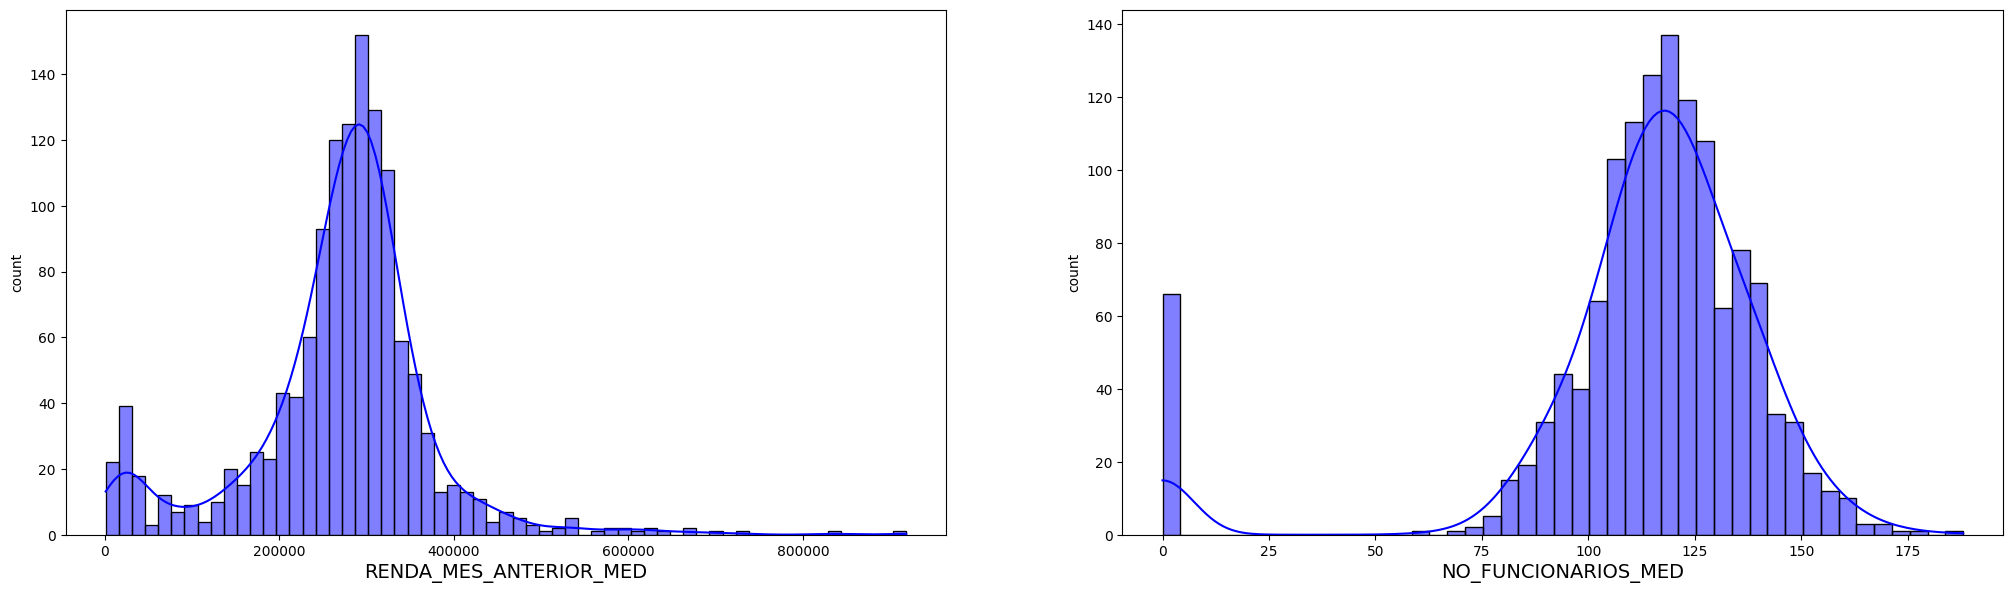

In [116]:
subp.histogram()

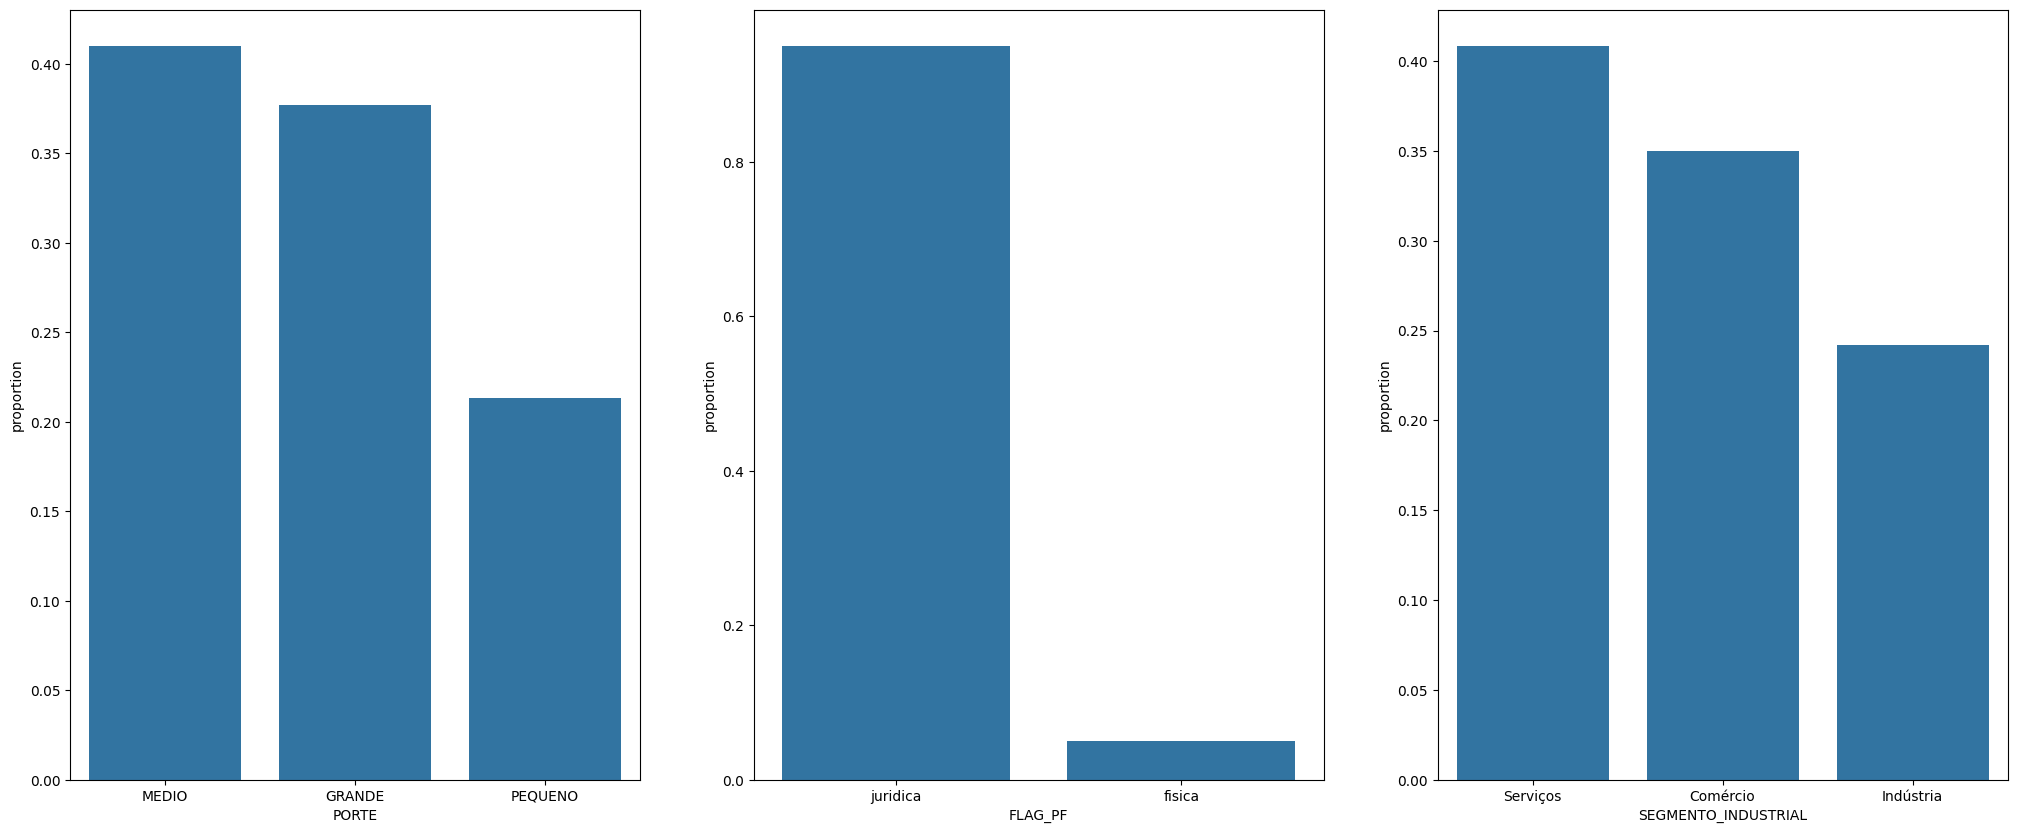

In [117]:
fig, ax = plt.subplots(ncols=3, sharex=False, sharey=False, figsize=(25, 10))
sns.barplot(df_exploratoria["PORTE"].value_counts(normalize=True), ax=ax[0])
sns.barplot(df_exploratoria["FLAG_PF"].value_counts(normalize=True), ax=ax[1])
sns.barplot(df_exploratoria["SEGMENTO_INDUSTRIAL"].value_counts(normalize=True), ax=ax[2]);

Verification of normality with QQ graph for the set at client level.

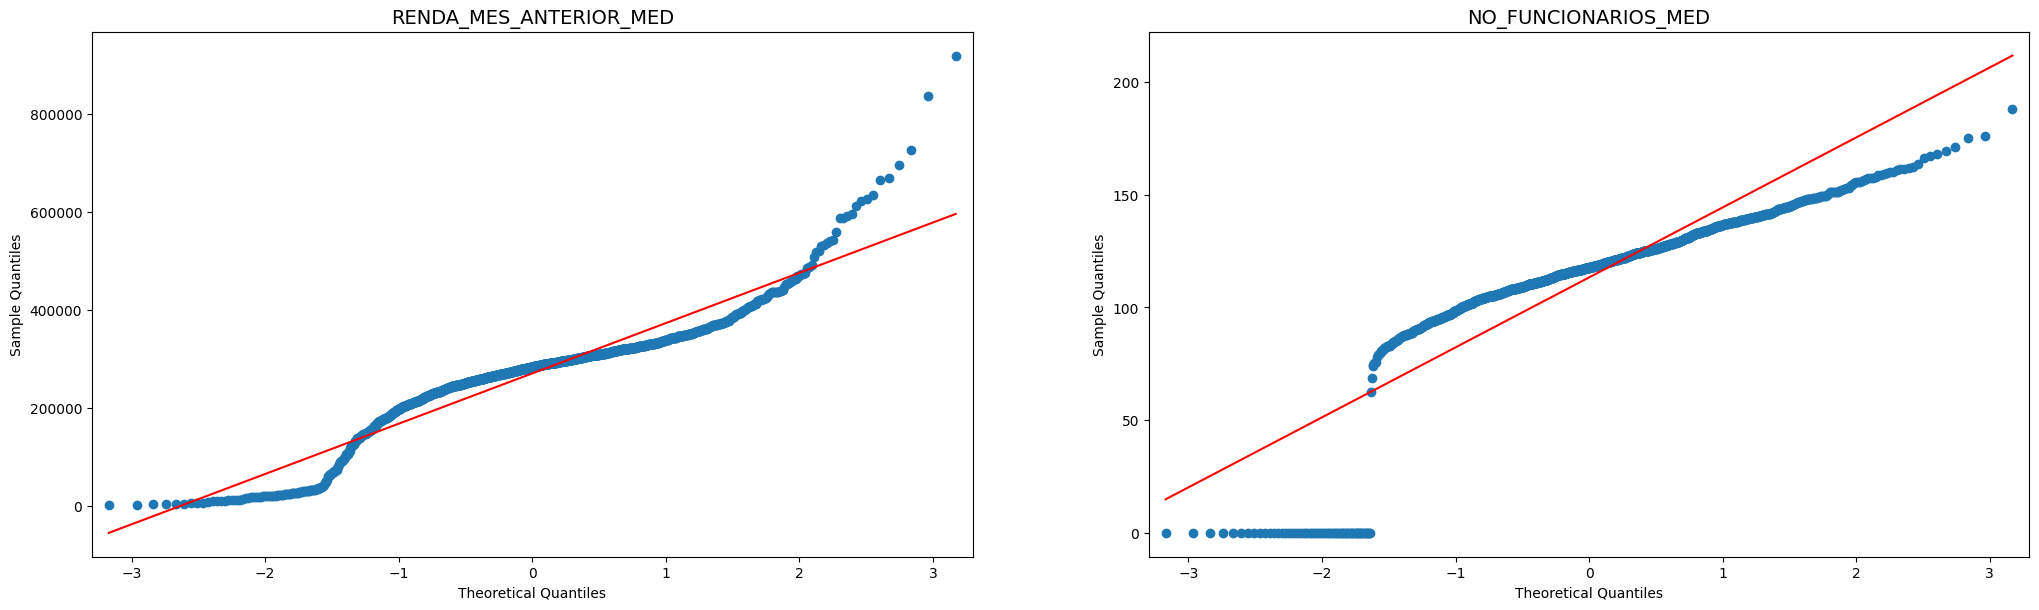

In [118]:
subp.qq_plot()

#### 3.3) Anomaly detection

Checking boxplots for the set at client level.

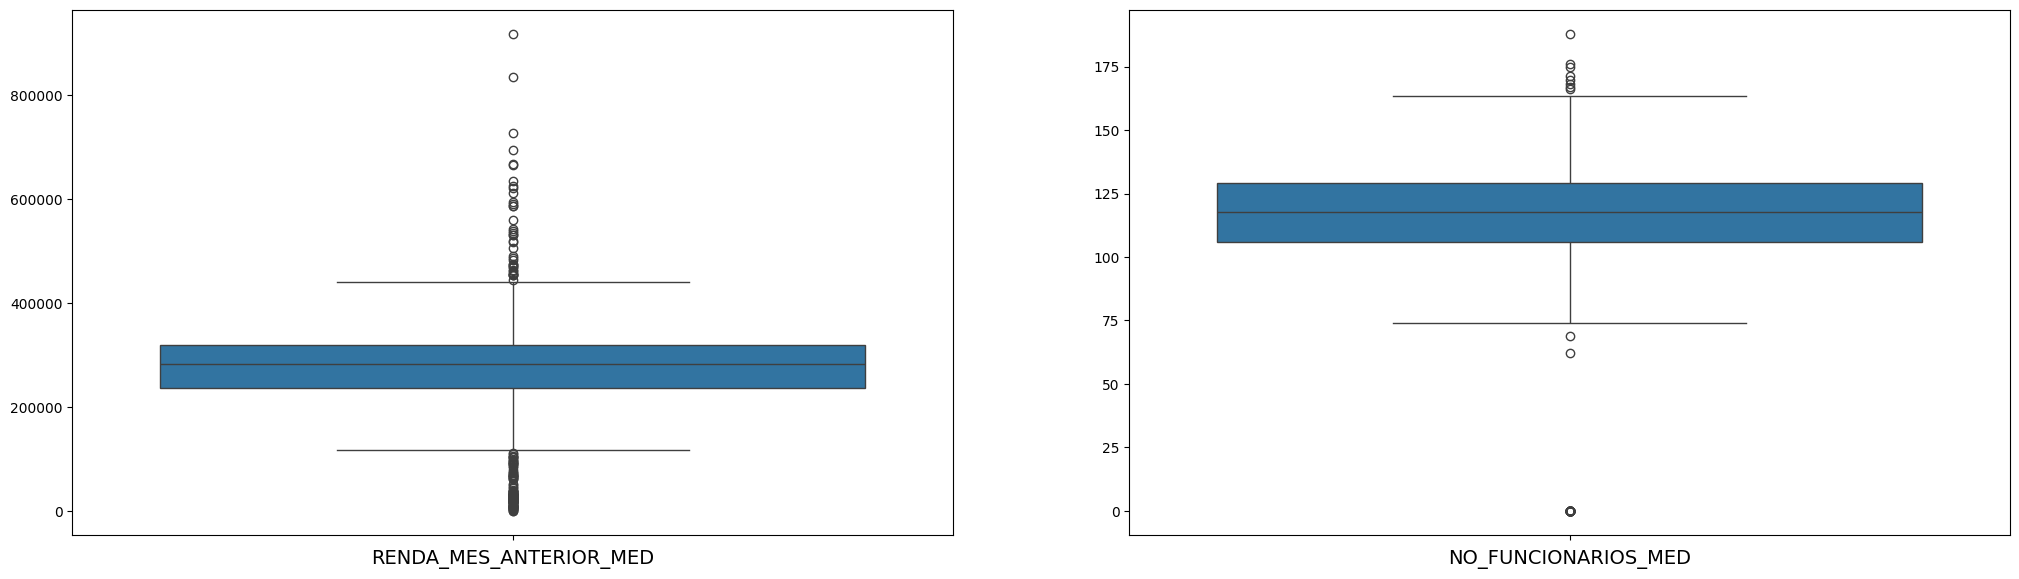

In [119]:
subp.boxplot()

#### 3.5) Missing data analysis

We will first investigate the missing data for the PORTE variable, using the set at customer level to see if there is any determining behavior.

In [120]:
df_exploratoria["PORTE"].unique()

array(['GRANDE', 'MEDIO', 'PEQUENO', nan], dtype=object)

count     41.000000
mean     113.316187
std       30.011194
min        0.000000
25%      110.205128
50%      118.038462
75%      130.142857
max      154.200000
Name: NO_FUNCIONARIOS_MED, dtype: float64

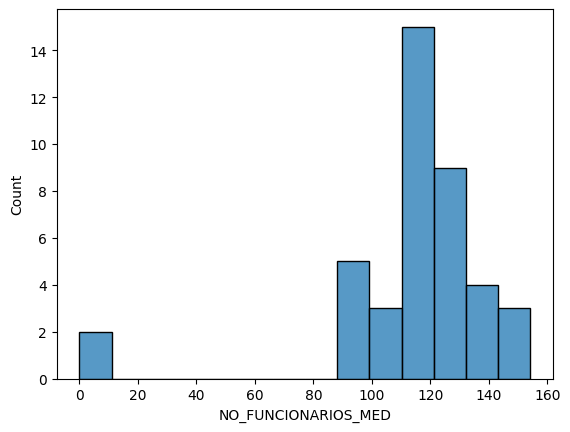

In [121]:
# Distribuição do número de colaboradores médio dentro do grupo de dados faltantes para a variável PORTE.
dados_porte_faltantes = df_exploratoria[df_exploratoria["PORTE"].isna()]["NO_FUNCIONARIOS_MED"]
display(dados_porte_faltantes.describe())
sns.histplot(dados_porte_faltantes);

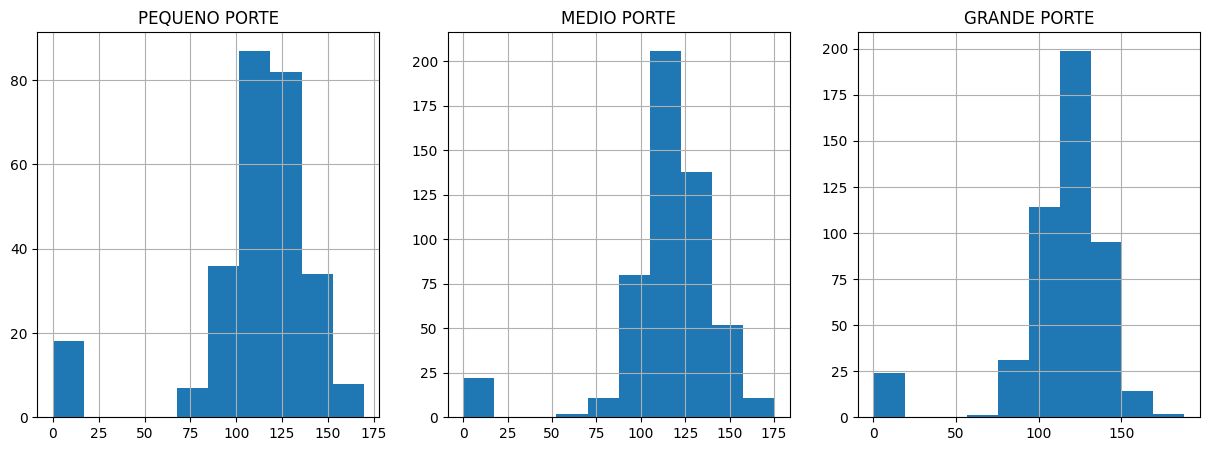

In [122]:
# Criando subplots:
fig, ax = plt.subplots(ncols=3, nrows=1, sharex=False, sharey=False, figsize=(15, 5))

# Distribuição do número de funcionários dos clientes de PEQUENO PORTE:
df_exploratoria[df_exploratoria["PORTE"]=="PEQUENO"]["NO_FUNCIONARIOS_MED"].hist(ax=ax[0])

# Distribuição do número de funcionários dos clientes de MEDIO PORTE:
df_exploratoria[df_exploratoria["PORTE"]=="MEDIO"]["NO_FUNCIONARIOS_MED"].hist(ax=ax[1])

# Distribuição do número de funcionários dos clientes de GRANDE PORTE:
df_exploratoria[df_exploratoria["PORTE"]=="GRANDE"]["NO_FUNCIONARIOS_MED"].hist(ax=ax[2])

ax[0].set_title("PEQUENO PORTE")
ax[1].set_title("MEDIO PORTE")
ax[2].set_title("GRANDE PORTE");

In [123]:
# Criando estatísticas:
estatisticas_pequeno_porte = df_exploratoria[df_exploratoria["PORTE"]=="PEQUENO"]["NO_FUNCIONARIOS_MED"].describe()
estatisticas_medio_porte = df_exploratoria[df_exploratoria["PORTE"]=="MEDIO"]["NO_FUNCIONARIOS_MED"].describe()
estatisticas_grande_porte = df_exploratoria[df_exploratoria["PORTE"]=="GRANDE"]["NO_FUNCIONARIOS_MED"].describe()

estatisticas_pequeno_porte.name = "PEQUENO_PORTE"
estatisticas_medio_porte.name = "MEDIO_PORTE"
estatisticas_grande_porte.name = "GRANDE_PORTE"

estatisticas_compiladas = pd.concat([estatisticas_pequeno_porte, estatisticas_medio_porte, estatisticas_grande_porte], axis=1)
estatisticas_compiladas

,PEQUENO_PORTE,MEDIO_PORTE,GRANDE_PORTE
count,272.000000,522.000000,480.000000
mean,110.284524,114.440535,113.853679
std,33.982374,29.441213,31.102227
min,0.000000,0.000000,0.000000
25%,103.561008,106.202267,107.861111
50%,116.674242,117.729839,118.075000
75%,128.336727,129.148279,129.310526
max,169.564103,175.000000,188.000000


Secondly, let's briefly analyze the missing data for the INDUSTRIAL SEGMENT variable, its relationship with the OVERALL_INCOME and SIZE variables.

In [124]:
df_exploratoria["SEGMENTO_INDUSTRIAL"].unique()

array(['Indústria', 'Comércio', 'Serviços', nan], dtype=object)

count     83.000000
mean      23.892073
std       48.307701
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      157.750000
Name: NO_FUNCIONARIOS_MED, dtype: float64

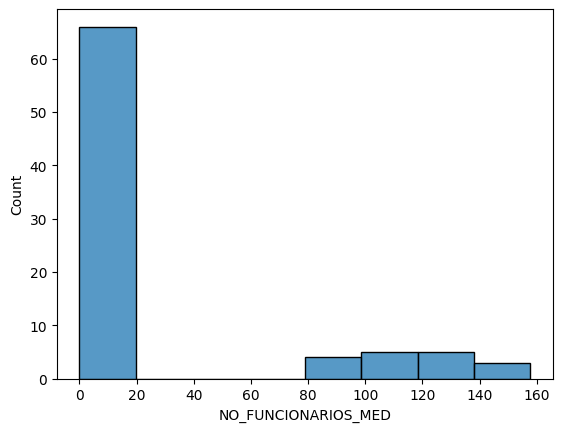

In [125]:
# Distribuição dos dados faltantes para SEGMENTO INDUSTRIAL do Número médio de funcionários.
dados_segmento_faltante_funcionarios = df_exploratoria[df_exploratoria["SEGMENTO_INDUSTRIAL"].isna()]["NO_FUNCIONARIOS_MED"]
display(dados_segmento_faltante_funcionarios.describe())
sns.histplot(dados_segmento_faltante_funcionarios);

count        83.000000
mean      75566.843203
std      110458.489666
min        1861.000000
25%       18576.000000
50%       26418.500000
75%       36029.226190
max      368652.428571
Name: RENDA_MES_ANTERIOR_MED, dtype: float64

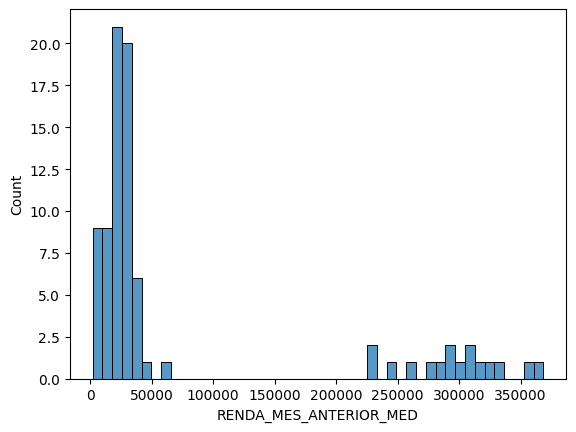

In [126]:
# Distribuição dos dados faltantes para SEGMENTO INDUSTRIAL do Número médio de funcionários.
dados_segmento_faltante_renda = df_exploratoria[df_exploratoria["SEGMENTO_INDUSTRIAL"].isna()]["RENDA_MES_ANTERIOR_MED"]
display(dados_segmento_faltante_renda.describe())
sns.histplot(dados_segmento_faltante_renda);

#### 3.6) Correlations

In [127]:
class Correlations_plot:
    def __init__(self, df) -> None:
        self.dataframe = df
    
    def pearson(self):
        correlations = self.dataframe.corr()
        mask =  np.zeros_like(correlations)
        mask[np.triu_indices_from(mask)] = True
        plt.figure(figsize=(27, 10))
        sns.heatmap(correlations, annot=True, mask=mask, cmap="crest", annot_kws={"size": 20})
        plt.xticks(fontsize=20, rotation=90)
        plt.yticks(fontsize=20, rotation=360);
    
    def spearman(self):
        correlations = self.dataframe.corr(method="spearman")
        mask =  np.zeros_like(correlations)
        mask[np.triu_indices_from(mask)] = True
        plt.figure(figsize=(27, 10))
        sns.heatmap(correlations, annot=True, mask=mask, cmap="crest", annot_kws={"size": 20})
        plt.xticks(fontsize=20, rotation=90)
        plt.yticks(fontsize=20, rotation=360);

In [128]:
variaveis_interesse = ["VALOR_TOTAL_MES", "TAXA_MED_TRANSACAO", 
                       "PRAZO_PAGAMENTO_MED_TRANSACAO", "RENDA_MES_ANTERIOR",
                       "NO_FUNCIONARIOS","INADIMPLENCIA_MES"]
corr_plots = Correlations_plot(df_modelo[variaveis_interesse])

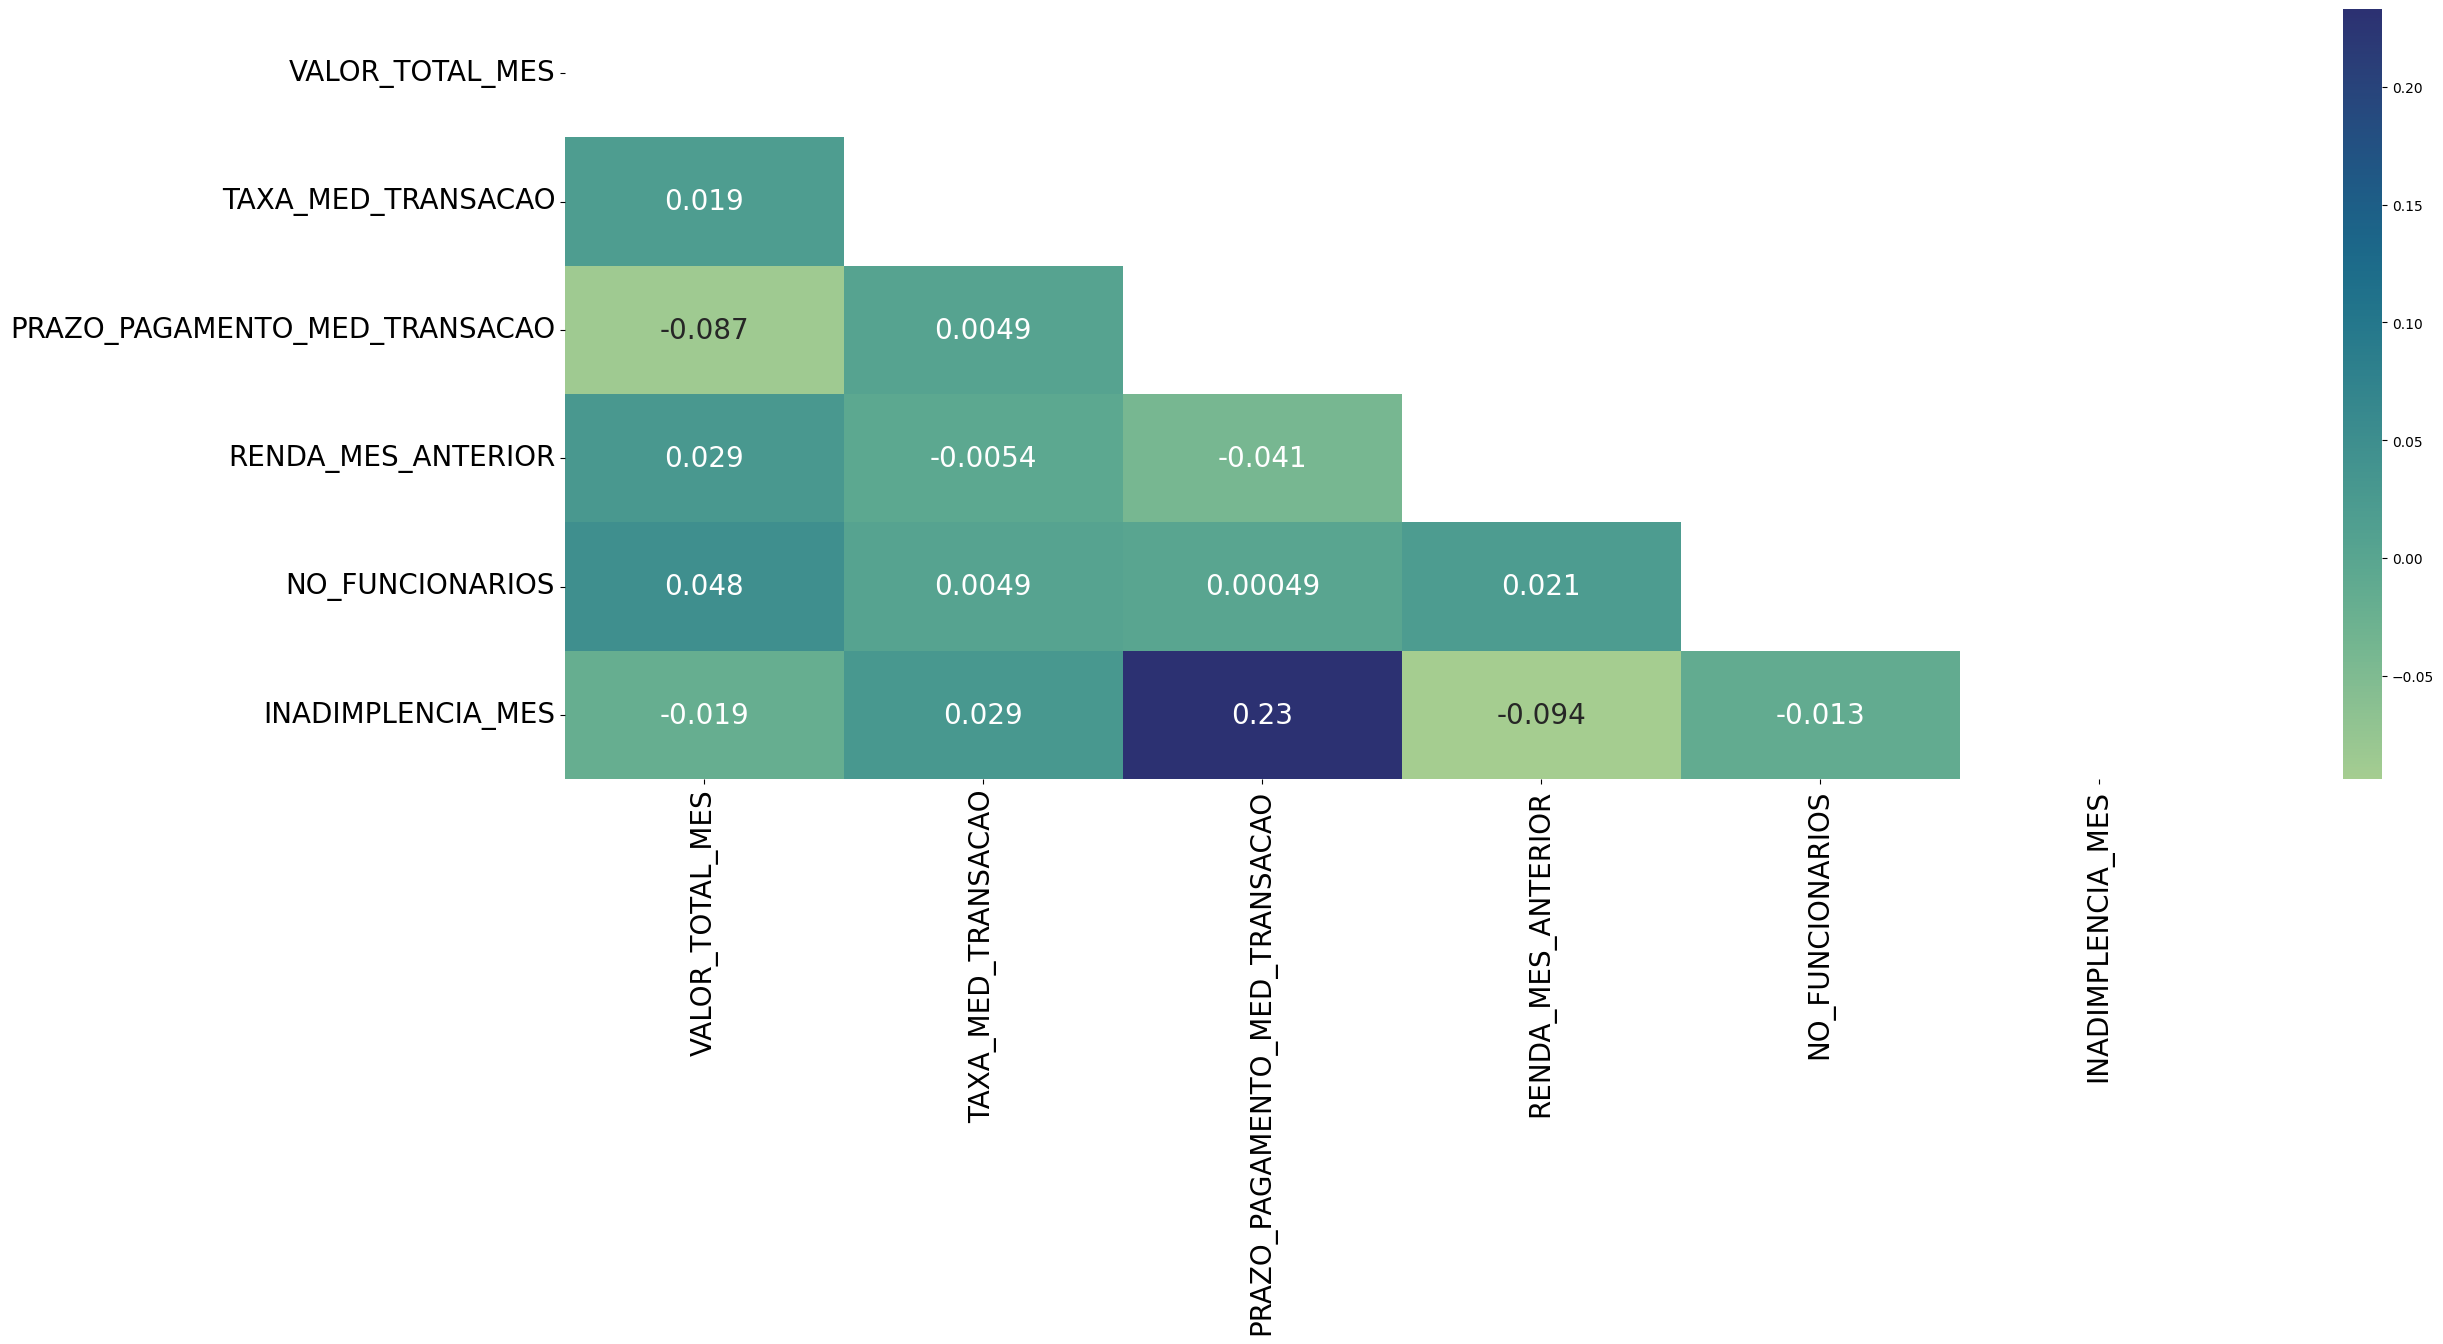

In [129]:
corr_plots.spearman()

##### Conclusions:

- There is an imbalance in the proportion of Delinquents (7%) at the transaction level.
- The average interest rate charged on transactions is 6.79%.
- The mean, median, and standard deviation of the number of employees for clients with missing PORTE (Size) are closer to the statistics of clients with a GRANDE (Large) size.
- Most observations with missing SEGMENTO_INDUSTRIAL (Industry Segment) have an average number of employees equal to 0, and an average income of less than 36 thousand reais.
- Histograms and QQ-plots indicate non-normality of the variables RENDA_MES_ANTERIOR_MED (Average Income Previous Month) and NO_FUNCIONARIOS_MED (Average Number of Employees) at the customer level.
- There are outliers in the variables RENDA_MES_ANTERIOR_MED and NO_FUNCIONARIOS_MED of the dataset at the customer level, according to the Boxplot.
- The highest correlation is between PRAZO_PAGAMENTO_MED_TRANSACAO (Average Payment Term per Transaction) and INADIMPLENCIA_MES (Monthly Delinquency).
- Most of our clients are MÉDIO PORTE (Medium Size).
- Most of our clients are from the SERVIÇO (Service) SEGMENTO_INDUSTRIAL.
- Most of our clients are JURÍDICA (Legal Entity) persons.


#### 3.7) Relacionamentos entre variáveis

In [130]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18552 entries, 0 to 18551
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID_CLIENTE                     18552 non-null  object 
 1   SAFRA_REF                      18552 non-null  object 
 2   VALOR_TOTAL_MES                18552 non-null  float64
 3   TAXA_MED_TRANSACAO             18552 non-null  float64
 4   PRAZO_PAGAMENTO_MED_TRANSACAO  18552 non-null  float64
 5   INADIMPLENCIA_MES              18552 non-null  int64  
 6   RENDA_MES_ANTERIOR             18552 non-null  float64
 7   NO_FUNCIONARIOS                18552 non-null  int64  
 8   FLAG_PF                        18552 non-null  object 
 9   SEGMENTO_INDUSTRIAL            18149 non-null  object 
 10  PORTE                          18071 non-null  object 
dtypes: float64(4), int64(2), object(5)
memory usage: 1.6+ MB


##### 3.7.1) Relacionamento entre VALOR_TOTAL ao longo do tempo

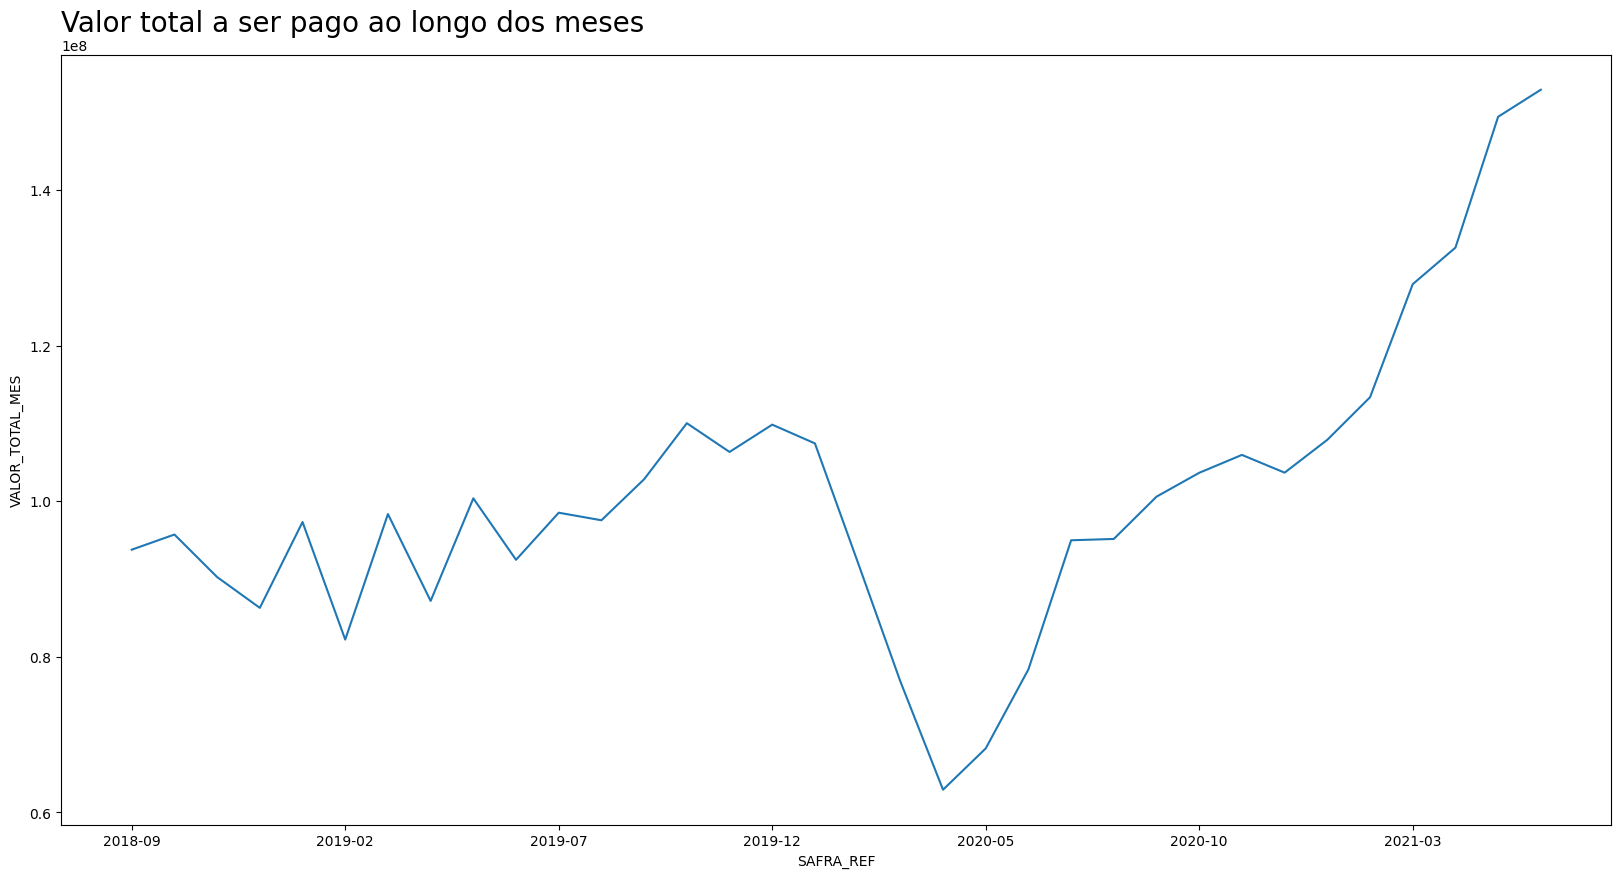

In [131]:
dados_valor_total_tempo = df_modelo.groupby("SAFRA_REF").agg({"VALOR_TOTAL_MES":"sum"}).reset_index()
plt.figure(figsize=(20, 10))
plt.title("Valor total a ser pago ao longo dos meses", loc="left", fontdict={"size":20})
plt.xticks(range(0, len(dados_valor_total_tempo["SAFRA_REF"]), 5))
sns.lineplot(x=dados_valor_total_tempo["SAFRA_REF"], y=dados_valor_total_tempo["VALOR_TOTAL_MES"]);

Conclusions:

- There is a noticeable increase in the total value paid by customers in relation to the loan over the months.


##### 3.7.2) Behavior of INDIMPLENCIA_MES over the months

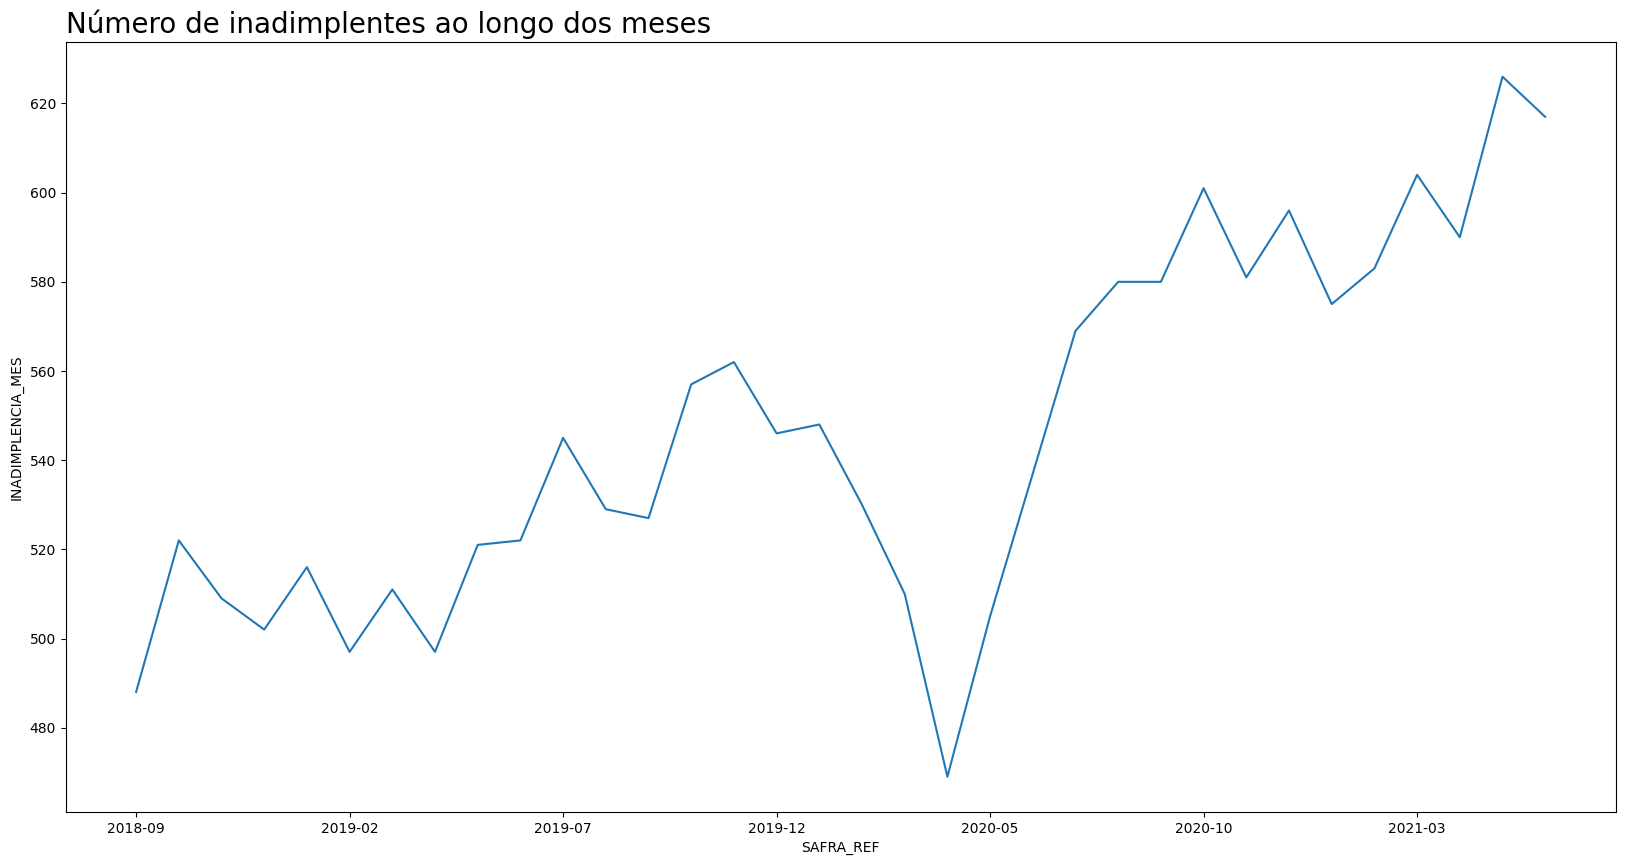

In [132]:
dados_contagem_inadimplentes_mes = df_modelo.groupby("SAFRA_REF").agg({"INADIMPLENCIA_MES":"count"}).reset_index()
plt.figure(figsize=(20, 10))
plt.title("Número de inadimplentes ao longo dos meses", loc="left", fontdict={"size":20})
plt.xticks(range(0, len(dados_contagem_inadimplentes_mes["SAFRA_REF"]), 5))
sns.lineplot(x=dados_contagem_inadimplentes_mes["SAFRA_REF"], y=dados_contagem_inadimplentes_mes["INADIMPLENCIA_MES"]);

Conclusions:

- There is a noticeable increase in the number of delinquent customers over the months, although there is a drop in 2020-04.


##### 3.7.3) Relation between SEGMENTO_INDUSTRIAL and PORTE

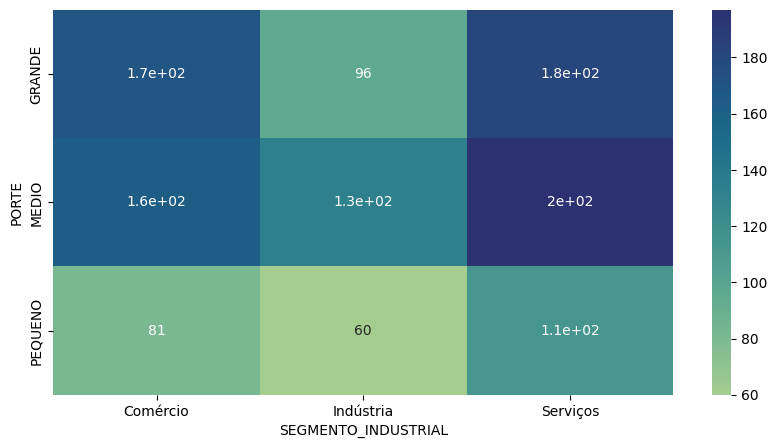

In [133]:
plt.figure(figsize=(10, 5))
cross = pd.crosstab(df_exploratoria["PORTE"], df_exploratoria["SEGMENTO_INDUSTRIAL"])
plt.yticks(rotation=90)
sns.heatmap(cross, annot=True, cmap="crest", cbar=True);

Conclusions:

- The largest number of customers are those of medium size and that operate in the service segment.
- The smallest number of customers are those of small size and that operate in industry.


##### 3.7.4) Relation between SEGMENTO_INDUSTRIAL and FLAG_PF

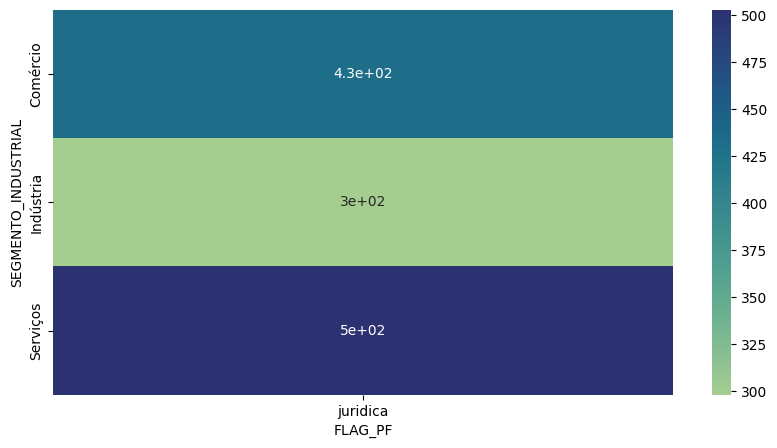

In [134]:
plt.figure(figsize=(10, 5))
cross = pd.crosstab(df_exploratoria["SEGMENTO_INDUSTRIAL"], df_exploratoria["FLAG_PF"])
plt.yticks(rotation=90)
sns.heatmap(cross, annot=True, cmap="crest", cbar=True);

Conclusions:

- There are no customers characterized as individuals who fall into the industrial segments. This behavior is expected since industrial segments are characteristic of legal entities.


##### 3.7.5) Relation betwenn PORTE and FLAG_PF

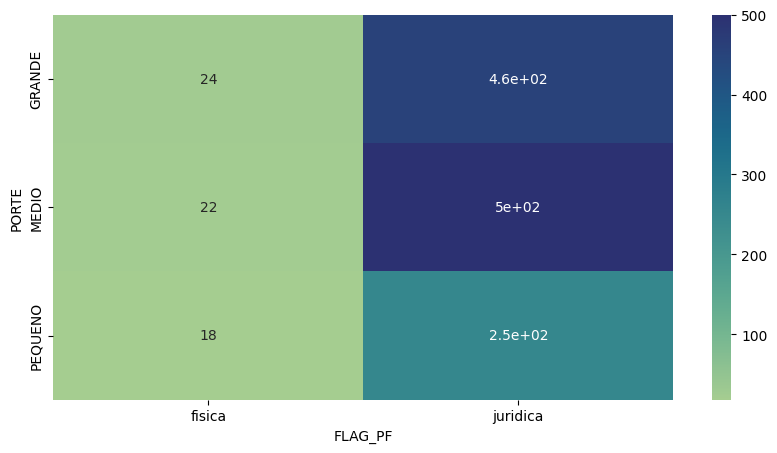

In [135]:
plt.figure(figsize=(10, 5))
cross = pd.crosstab(df_exploratoria["PORTE"], df_exploratoria["FLAG_PF"])
plt.yticks(rotation=90)
sns.heatmap(cross, annot=True, cmap="crest", cbar=True);

Conclusions:

- The largest number of customers, within the class of individuals (natural persons), are large size.


### 4) Preprocessing

In [136]:
X  = df_modelo.drop(columns="INADIMPLENCIA_MES")
y = df_modelo["INADIMPLENCIA_MES"]
X.set_index(["ID_CLIENTE", "SAFRA_REF"], inplace=True)

In [137]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### 4.1) Imputing missing data

In [138]:
imputer = SimpleImputer(strategy="most_frequent")
X_train[["SEGMENTO_INDUSTRIAL", "PORTE"]] = imputer.fit_transform(X_train[["SEGMENTO_INDUSTRIAL", "PORTE"]])
X_valid[["SEGMENTO_INDUSTRIAL", "PORTE"]] = imputer.transform(X_valid[["SEGMENTO_INDUSTRIAL", "PORTE"]])

#### 4.2) Encoding categorical variables

In [139]:
variaveis_categoricas = ["SEGMENTO_INDUSTRIAL", "PORTE", "FLAG_PF"]
encoding = OneHotEncoder(sparse_output=False)
enconded_train = encoding.fit_transform(X_train[variaveis_categoricas])
encoded_valid = encoding.transform(X_valid[variaveis_categoricas])

colunas = encoding.get_feature_names_out()
X_train[colunas] = enconded_train
X_valid[colunas] = encoded_valid

X_train.drop(columns=variaveis_categoricas, inplace=True)
X_valid.drop(columns=variaveis_categoricas, inplace=True)

#### 4.3) Featuring engineering

We will construct the variable NUMERO_TRANSACOES per month for each customer

In [140]:
def construindo_numero_transacoes(df):
    copia = df.copy()
    contagem_inadimplentes_mes =  copia.groupby(["ID_CLIENTE", "SAFRA_REF"]).agg({"INADIMPLENCIA":"count"}).reset_index()
    contagem_inadimplentes_mes.rename(columns={"INADIMPLENCIA":"NUMERO_TRANSACOES"}, inplace=True)
    return contagem_inadimplentes_mes

In [141]:
contagem_inadimplentes_mes = construindo_numero_transacoes(df_raw_base_pagamento)
X_train = X_train.merge(contagem_inadimplentes_mes, how="inner", on=["ID_CLIENTE", "SAFRA_REF"])
X_valid = X_valid.merge(contagem_inadimplentes_mes, how="inner", on=["ID_CLIENTE", "SAFRA_REF"])

#### 4.4) Transforming numeric variables using MinMax scaler

In [142]:
num_var = ['VALOR_TOTAL_MES', 
           'TAXA_MED_TRANSACAO',
           'PRAZO_PAGAMENTO_MED_TRANSACAO', 
           'RENDA_MES_ANTERIOR',
           'NO_FUNCIONARIOS',
           "NUMERO_TRANSACOES"]

In [143]:
min_max = MinMaxScaler()
X_train[num_var] = min_max.fit_transform(X_train[num_var])
X_valid[num_var] = min_max.transform(X_valid[num_var])

X_train.set_index(["ID_CLIENTE", "SAFRA_REF"], inplace=True)
X_valid.set_index(["ID_CLIENTE", "SAFRA_REF"], inplace=True)

#### 4.5) Feature selection

In [144]:
class feature_selector:
    seed = 42
    def __init__(self, X, y) -> None:
        self.X_train = X
        self.y_train = y
    
    def  randomforestC_imp(self) -> None:
        model = RandomForestClassifier(random_state=feature_selector.seed)
        model.fit(self.X_train, self.y_train)
        series = pd.Series(index=model.feature_names_in_, data=model.feature_importances_).sort_values(ascending=False)

        plt.figure(figsize=(15, 15))
        plt.title("RandomForest Importance")
        plt.xlabel("Importance")
        sns.barplot(x=series.values, y=series.index)
        

    def xgbC_imp(self) -> None:
        model = XGBClassifier(random_state=feature_selector.seed)
        model.fit(self.X_train, self.y_train)
        series = pd.Series(index=model.feature_names_in_, data=model.feature_importances_).sort_values(ascending=False)

        plt.figure(figsize=(10, 5))
        plt.title("XGBoost Feature Importance")
        plt.xlabel("Importance")
        ax = sns.barplot(y=series.index, x=series.values)
        ax.set_ylabel(None)
    
    def refcv(self, min_features):
        
        models = {
            "RandomForestR":RandomForestClassifier(random_state=feature_selector.seed),
            "ExtraTreeR":ExtraTreesClassifier(random_state=feature_selector.seed),
            "XGB":XGBClassifier(random_state=feature_selector.seed)
        }

        splits=10
        step = 1
        cross = StratifiedKFold(n_splits=splits, random_state=feature_selector.seed, shuffle=True)
        ind = [f"Columns {i}" for i in range(min_features, len(self.X_train.columns) + 1)]
        df = pd.DataFrame(index=ind)
        
        minimo = -np.inf
        name = ""
        for key, model in models.items():
            rfecv = RFECV(estimator=model, step=step, cv=cross, min_features_to_select=min_features, scoring="recall")
            rfecv.fit(self.X_train, self.y_train)
            root_mean = rfecv.cv_results_["mean_test_score"]
            df[key] = root_mean
            best_value = root_mean[np.argmax(root_mean)]

            if best_value > minimo:
                minimo = best_value
                best_features = rfecv.support_
                name = key

        df_features = pd.DataFrame(columns=self.X_train.columns, data=best_features.reshape(1, -1), index=[name])
    
        return df,  df_features.transpose()

In [145]:
selector = feature_selector(X_train, y_train)

#### 4.5.1) Feature importance using Extreme Gradient Boosting

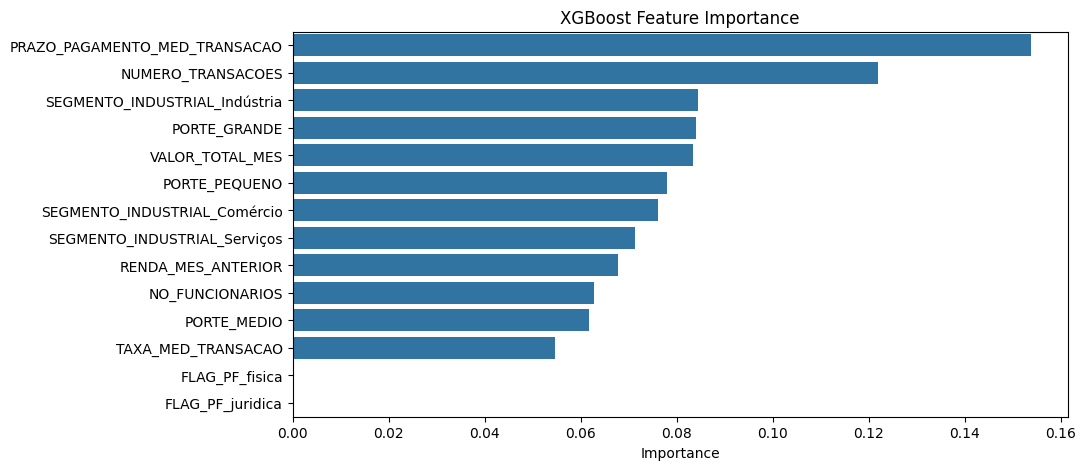

In [146]:
# XGBoost Classifier Importance:
selector.xgbC_imp()

#### 4.5.2) Feature selection using Eliminação Recursiva

Recursive elimination is being done using the F1-score metric, which is the harmonic mean between recall and precision.


In [147]:
# Recusive feature elimination method:
df_results, df_best_features = selector.refcv(min_features=10)

In [148]:
display(df_results)
display(df_best_features)

,RandomForestR,ExtraTreeR,XGB
Columns 10,0.168157,0.117472,0.233155
Columns 11,0.162785,0.115070,0.250456
Columns 12,0.168720,0.111502,0.240890
Columns 13,0.154430,0.111509,0.240890
Columns 14,0.147861,0.101362,0.240890


,XGB
VALOR_TOTAL_MES,True
TAXA_MED_TRANSACAO,False
PRAZO_PAGAMENTO_MED_TRANSACAO,True
RENDA_MES_ANTERIOR,True
NO_FUNCIONARIOS,True
SEGMENTO_INDUSTRIAL_Comércio,True
SEGMENTO_INDUSTRIAL_Indústria,True
SEGMENTO_INDUSTRIAL_Serviços,True
PORTE_GRANDE,True
PORTE_MEDIO,True


In [149]:
colunas_selecionadas = df_best_features[df_best_features["XGB"] == True].index
colunas_selecionadas

Index(['VALOR_TOTAL_MES', 'PRAZO_PAGAMENTO_MED_TRANSACAO',
       'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'SEGMENTO_INDUSTRIAL_Comércio',
       'SEGMENTO_INDUSTRIAL_Indústria', 'SEGMENTO_INDUSTRIAL_Serviços',
       'PORTE_GRANDE', 'PORTE_MEDIO', 'PORTE_PEQUENO', 'NUMERO_TRANSACOES'],
      dtype='object')

In [150]:
X_train_reduzido, X_valid_reduzido = X_train[colunas_selecionadas], X_valid[colunas_selecionadas]

Conclusions:

- The Extreme Gradient Boosting algorithm indicates that the most important variables are all but the binary variables FLAG_PF_fisica (Flag Individual Person) and FLAG_PF_juridica (Flag Legal Entity). 
- The results of Recursive Feature Elimination suggest the elimination of the variables TAXA_MED_TRANSACAO (Average Transaction Rate), FLAG_PF_fisica, and FLAG_PF_juridica.
- The Extreme Gradient Boosting algorithm obtained the best f1-score metrics, in the sets partitioned by StratifiedKFold.


### 5) Modeling

For the modeling we will choose the Recall metric, since for the default problem the error associated with the False negative is more costly than that generated by the False positive. We will therefore choose the best model and optimize it based on this metric.

#### 5.1) Selection the best algorithm

In [151]:
class Best_model_selector:
    seed = 42
    cv = 10

    def __init__(self, X_train, y_train) -> None:
        self.X_train = X_train
        self.y_train = y_train
    
    def best_model(self, scoring='recall'):
        results = {}
        dicionario_modelos = { 
                    "RandomForestR":RandomForestClassifier(random_state=Best_model_selector.seed, class_weight='balanced'),
                    "ExtraTreeR":ExtraTreesClassifier(random_state=Best_model_selector.seed, class_weight='balanced'),
                    "XGB":XGBClassifier(random_state=Best_model_selector.seed, scale_pos_weight=self._weight_xgboost()),
                    "MLP":MLPClassifier(random_state=Best_model_selector.seed, max_iter=2000)
                    }
        for name, model in dicionario_modelos.items():
            k_fold = StratifiedKFold(n_splits=Best_model_selector.cv, random_state=Best_model_selector.seed, shuffle=True)
            result = cross_validate(model, self.X_train, self.y_train, cv=k_fold, scoring=[scoring])
            results[name] = result['test_' + scoring]
            
        return pd.DataFrame(data=results)
            
    def _weight_xgboost(self):
        n_negativos = (self.y_train == 0).sum()
        n_positivos = (self.y_train == 1).sum()
        return n_negativos/n_positivos

In [152]:
model_selector = Best_model_selector(X_train_reduzido, y_train)

In [153]:
resultados = model_selector.best_model()

In [154]:
resultados.describe()

,RandomForestR,ExtraTreeR,XGB,MLP
count,10.000000,10.000000,10.000000,10.000000
mean,0.141884,0.126985,0.524116,0.082863
std,0.034939,0.031571,0.038197,0.028641
min,0.077844,0.071856,0.443114,0.035714
25%,0.127976,0.107330,0.519345,0.067258
50%,0.143713,0.130952,0.531330,0.083333
75%,0.159226,0.146038,0.546942,0.104309
max,0.208333,0.172619,0.571429,0.125000


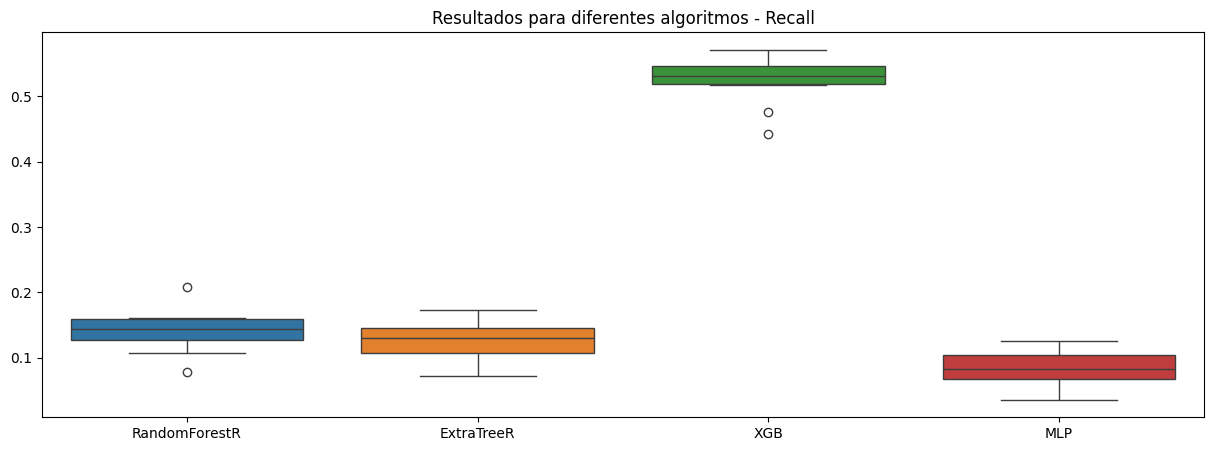

In [155]:
plt.figure(figsize=(15, 5))
plt.title("Resultados para diferentes algoritmos - Recall")
sns.boxplot(resultados)
plt.show()

Conclusion:

- We can conclude that the Extreme Gradient Boosting algorithm is the one we should choose, given the highest median value and the lowest variance value.


#### 5.2) Selection Hiperparameters

In [156]:
def tuning(X_train, y_train, modelo, params): 
    cv = 5
    score = "recall"   
    grid  = GridSearchCV(modelo, cv=cv, param_grid=params, 
                         scoring=score, 
                         n_jobs=-1,
                         return_train_score=True,
                         )

    grid.fit(X_train, y_train)

    best_index = grid.best_index_
    result = grid.cv_results_

    train_score = result['mean_train_score'][best_index]
    left_out = result['mean_test_score'][best_index]


    print(f"Train score: {train_score}")
    print(f"Left out data score: {left_out}")

    return grid.best_params_


In [157]:
parametros = {
    'n_estimators':[100, 120, 150],
    'max_depth':[5, 6, 7, 8],
    'eta':[0.3, 0.01, 0.001],
    'max_delta_step':[0, 0.5, 1],
    "lambda":[0.1, 0.2, 0.5, 1]
    }

peso = (y_train == 0).sum()/(y_train == 1).sum()
modelo = XGBClassifier(random_state=42, scale_pos_weight=peso)

In [158]:
melhor_conjunto_parametros = tuning(X_train_reduzido, y_train, modelo, parametros)

Train score: 0.8145497221083093
Left out data score: 0.7799751243781093


In [159]:
melhor_conjunto_parametros

{'eta': 0.001,
 'lambda': 1,
 'max_delta_step': 0,
 'max_depth': 5,
 'n_estimators': 120}

In [160]:
melhor_modelo = XGBClassifier(**melhor_conjunto_parametros)
melhor_modelo.fit(X_train_reduzido, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.001, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=120,
              n_jobs=None, ...)

In [161]:
def save_model(model, name):
    try:
        joblib.dump(model, "modelos/{}".format(name))
    except:
        os.makedirs("modelos")
        path = "modelos/{}".format(name)
        joblib.dump(model, path)

In [194]:
save_model(melhor_modelo, "xgboost.joblib")
save_model(encoding, "encoding.joblib")
save_model(min_max, "min_max.joblib")
save_model(imputer, "imputer.joblib")

Conclusions:

- We can observe that the model does not suffer from overfitting, in addition to resulting in a great recall metric for the Left Out set.


#### 5.3) Evaluation in the test set

In [919]:
def metrics(y_true, y_pred): 
    index_metrics = ['Accuracy', 'F1-score', 'Recall', 'Precision']
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    metrics_df = pd.DataFrame(dict(Metrics=[accuracy, f1, recall, precision]), index=index_metrics)
    return metrics_df


def compute_roc_curve(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score[:, 1], pos_label=1)
    auc = roc_auc_score(y_true, y_score[:, 1])
    plt.title("ROC Curve")
    sns.lineplot(x=fpr, y=tpr)
    sns.lineplot(x=fpr, y=fpr, color='r')
    plt.xlabel("False Postive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    return auc, fpr, tpr, thresholds

In [929]:
melhor_modelo = joblib.load("modelos/xgboost.joblib")
y_pred_proba = melhor_modelo.predict_proba(X_valid_reduzido)

Obtaning ROC curve (Retrieval operating characteristic)

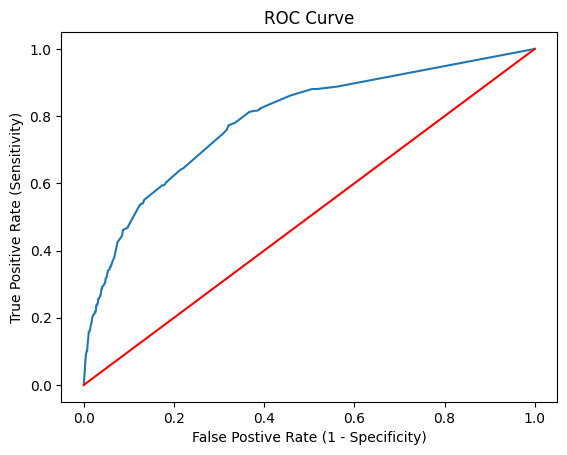

In [925]:
metrica_auc, false_positive_rate, true_positive_rate, thresholds = compute_roc_curve(y_valid, y_pred_proba)

We can then choose the threshold that maximizes the True Positive Rate (TPR), since this is the most important metric for reducing the number of false negatives at the cost of classifying observations that have no potential for default as positive.

In [927]:
# Encontrando o threshold que maximiza o TPR:
thresholds_max_tpr = thresholds[np.argmax(true_positive_rate)]
thresholds_max_tpr

np.float32(0.15837958)

In [933]:
# Previsões das classes no conjunto de validação:
y_pred = np.array([1 if i > thresholds_max_tpr else 0 for i in y_pred_proba[:, 1]])

In [936]:
# Métricas finais no conjunto de teste:
metrics(y_valid, y_pred)

,Metrics
Accuracy,0.489086
F1-score,0.281818
Recall,0.887828
Precision,0.167492


### 6) Predictions of the probabilities in the production set provided in the challenge

In [218]:
df_raw_test = pd.read_csv("dados/teste/base_pagamentos_teste.csv", dtype={"ID_CLIENTE":str})
df_preprocessados = pd.read_csv("dados/preprocessados/base_cadastro_info.csv", dtype={"ID_CLIENTE":str})
model = joblib.load("modelos/xgboost.joblib")
min_max = joblib.load("modelos/min_max.joblib")
encoding = joblib.load("modelos/encoding.joblib")
imputer = joblib.load("modelos/imputer.joblib")

colunas_numericas = min_max.feature_names_in_
colunas_categoricas_entradas = encoding.feature_names_in_
colunas_categoricas_saida = encoding.get_feature_names_out()

#### 6.1) Production data cleaning and preprocessing stage

In [219]:
def limpeza_pagamentos_teste(df):
    copia = df.copy()
    copia["ID_CLIENTE"] = copia["ID_CLIENTE"].astype(str)
    copia["DATA_VENCIMENTO"] = pd.to_datetime(copia["DATA_VENCIMENTO"])
    copia["DATA_EMISSAO_DOCUMENTO"] = pd.to_datetime(copia["DATA_EMISSAO_DOCUMENTO"])
    return copia

def constroi_prazo(df):
    copia = df.copy()
    prazo = copia["DATA_VENCIMENTO"] - copia["DATA_EMISSAO_DOCUMENTO"]
    copia["PRAZO_PAGAMENTO"] = prazo.dt.days
    return copia


def agregacoes(df):
    copia = df.copy()
    copia = copia.groupby(["ID_CLIENTE", "SAFRA_REF"])\
                            .agg({"VALOR_A_PAGAR":"sum",
                                "TAXA":"mean",
                                "PRAZO_PAGAMENTO":"mean",}).reset_index()
                            
    copia.rename(columns={"TAXA":"TAXA_MED_TRANSACAO", 
                          "VALOR_A_PAGAR":"VALOR_TOTAL_MES",
                          "PRAZO_PAGAMENTO":"PRAZO_PAGAMENTO_MED_TRANSACAO"}, inplace=True)
    
    return copia


def construindo_numero_transacoes(df):
    copia = df.copy()
    contagem_inadimplentes_mes =  copia.groupby(["ID_CLIENTE", "SAFRA_REF"]).agg({"DATA_EMISSAO_DOCUMENTO":"count"}).reset_index()
    contagem_inadimplentes_mes.rename(columns={"DATA_EMISSAO_DOCUMENTO":"NUMERO_TRANSACOES"}, inplace=True)
    return contagem_inadimplentes_mes

In [220]:
df_teste = limpeza_pagamentos_teste(df_raw_test)
df_teste = constroi_prazo(df_teste)
df_teste_agregado = agregacoes(df_teste)
df_teste_agregado = df_teste_agregado.merge(df_preprocessados, how="inner", on=["ID_CLIENTE", "SAFRA_REF"])
numero_transacoes = construindo_numero_transacoes(df_raw_test)
df_teste = df_teste_agregado.merge(numero_transacoes, how="inner", on=["ID_CLIENTE", "SAFRA_REF"])
df_teste.set_index(["ID_CLIENTE", "SAFRA_REF"], inplace=True)
df_teste[['SEGMENTO_INDUSTRIAL', 'PORTE']] = imputer.transform(df_teste[['SEGMENTO_INDUSTRIAL', 'PORTE']])
df_teste[colunas_numericas] = min_max.transform(df_teste[colunas_numericas])
variaveis_binarias = encoding.transform(df_teste[colunas_categoricas_entradas])
df_teste[colunas_categoricas_saida] = variaveis_binarias
df_teste.drop(columns=["FLAG_PF", "PORTE" , "SEGMENTO_INDUSTRIAL", 
                       "TAXA_MED_TRANSACAO", "FLAG_PF_juridica", "FLAG_PF_fisica"], inplace=True)

In [213]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3106 entries, ('1000372849175668062', '2021-08') to ('988707525807573448', '2021-10')
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   VALOR_TOTAL_MES                3106 non-null   float64
 1   PRAZO_PAGAMENTO_MED_TRANSACAO  3106 non-null   float64
 2   RENDA_MES_ANTERIOR             3106 non-null   float64
 3   NO_FUNCIONARIOS                3106 non-null   float64
 4   NUMERO_TRANSACOES              3106 non-null   float64
 5   SEGMENTO_INDUSTRIAL_Comércio   3106 non-null   float64
 6   SEGMENTO_INDUSTRIAL_Indústria  3106 non-null   float64
 7   SEGMENTO_INDUSTRIAL_Serviços   3106 non-null   float64
 8   PORTE_GRANDE                   3106 non-null   float64
 9   PORTE_MEDIO                    3106 non-null   float64
 10  PORTE_PEQUENO                  3106 non-null   float64
dtypes: float64(11)
memory usage: 315.6+ KB


#### 6.2) Predicting the probability of default

In [223]:
y_pred_prob_teste = model.predict_proba(df_teste[model.feature_names_in_])

In [224]:
y_pred_prob_teste

array([[0.82523704, 0.17476293],
       [0.84162045, 0.15837958],
       [0.83059514, 0.16940486],
       ...,
       [0.8268922 , 0.17310782],
       [0.83737504, 0.16262493],
       [0.8268922 , 0.17310782]], dtype=float32)

In [232]:
base_final = df_teste.reset_index()[["ID_CLIENTE", "SAFRA_REF"]].copy()
base_final["INADIMPLENTE"] = y_pred_prob_teste[:, 1]
base_final.to_csv("base_resultado.csv", index=False)